# Updates

In [1]:
# !pip install -U transformers
# !pip install -U accelerate

After updating packages, restart the session and then start your notebook from imports.

# Imports

In [43]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter
import re

from nltk.corpus import stopwords
from tqdm import trange

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Load model

In [3]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}

In [4]:
def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

Good luck :)

### Load Data

In [39]:
imdb_data = pd.read_json('imdb\/train_imdb.jsonl', lines=True)
imdb_data_unlabeled = pd.read_json('imdb\/aug_imdb_unlabeled.jsonl', lines=True)

### EDA

In [6]:
print(imdb_data.shape)
imdb_data.head(10)

(150, 3)


,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."
5,"this movie maybe really bad, but it is alot of...",1,"[0.0058481544000000005, -0.1326265633, 0.18759..."
6,"besides being boring, the scenes were oppressi...",0,"[0.1397939026, -0.021955709900000002, 0.169891..."
7,this is exactly the sort of saturday matinee s...,0,"[0.0405324325, 0.0174655784, 0.1514206231, 0.0..."
8,"very slick, very pre-hays code, and still very...",1,"[0.039149038500000004, -0.0511390641, 0.348277..."
9,i like this film a lot. it has a wonderful che...,1,"[-0.1012975574, 0.12617483740000002, 0.0768608..."


<Axes: xlabel='label'>

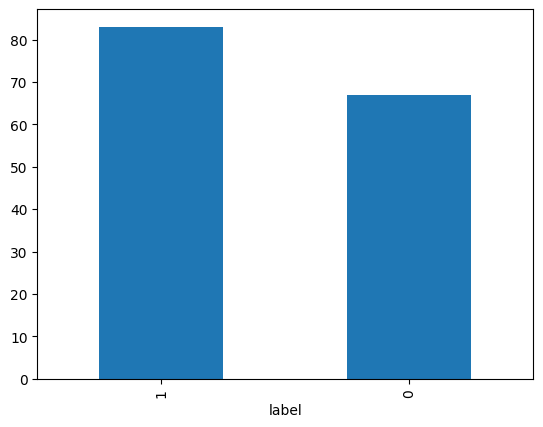

In [7]:
imdb_data['label'].value_counts().plot(kind='bar')

#### Counts and Lenght

Start by checking how long the reviews are

Character count
- Word count
- Mean word length
- Mean sentence length

In [8]:
lenght = len(imdb_data['text'][0])
print(f'Length of a sample review: {lenght}')

Length of a sample review: 382


In [9]:
imdb_data['Length'] = imdb_data['text'].str.len()
imdb_data.head(10)

,text,label,embedding,Length
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000...",382
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0....",702
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0....",684
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0....",653
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000...",238
5,"this movie maybe really bad, but it is alot of...",1,"[0.0058481544000000005, -0.1326265633, 0.18759...",504
6,"besides being boring, the scenes were oppressi...",0,"[0.1397939026, -0.021955709900000002, 0.169891...",267
7,this is exactly the sort of saturday matinee s...,0,"[0.0405324325, 0.0174655784, 0.1514206231, 0.0...",461
8,"very slick, very pre-hays code, and still very...",1,"[0.039149038500000004, -0.0511390641, 0.348277...",571
9,i like this film a lot. it has a wonderful che...,1,"[-0.1012975574, 0.12617483740000002, 0.0768608...",693


In [10]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [11]:
imdb_data['Word_count'] = imdb_data['text'].apply(word_count)
imdb_data.head(10)

,text,label,embedding,Length,Word_count
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000...",382,71
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0....",702,126
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0....",684,123
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0....",653,125
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000...",238,44
5,"this movie maybe really bad, but it is alot of...",1,"[0.0058481544000000005, -0.1326265633, 0.18759...",504,96
6,"besides being boring, the scenes were oppressi...",0,"[0.1397939026, -0.021955709900000002, 0.169891...",267,47
7,this is exactly the sort of saturday matinee s...,0,"[0.0405324325, 0.0174655784, 0.1514206231, 0.0...",461,82
8,"very slick, very pre-hays code, and still very...",1,"[0.039149038500000004, -0.0511390641, 0.348277...",571,103
9,i like this film a lot. it has a wonderful che...,1,"[-0.1012975574, 0.12617483740000002, 0.0768608...",693,124


In [12]:
def visualize(col):
    # Filter the data to include only rows where the label is 0 or 1
    filtered_data = imdb_data[imdb_data['label'].isin([0, 1])]
    
    plt.figure(figsize=(14, 6))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='label', y=col, data=filtered_data)
    plt.title(f'Boxplot of {col}')
    plt.xlabel('Label')
    plt.ylabel(col)
    
    # KDE plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=filtered_data, x=col, hue='label', common_norm=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Example usage
# visualize('your_column_name')


d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


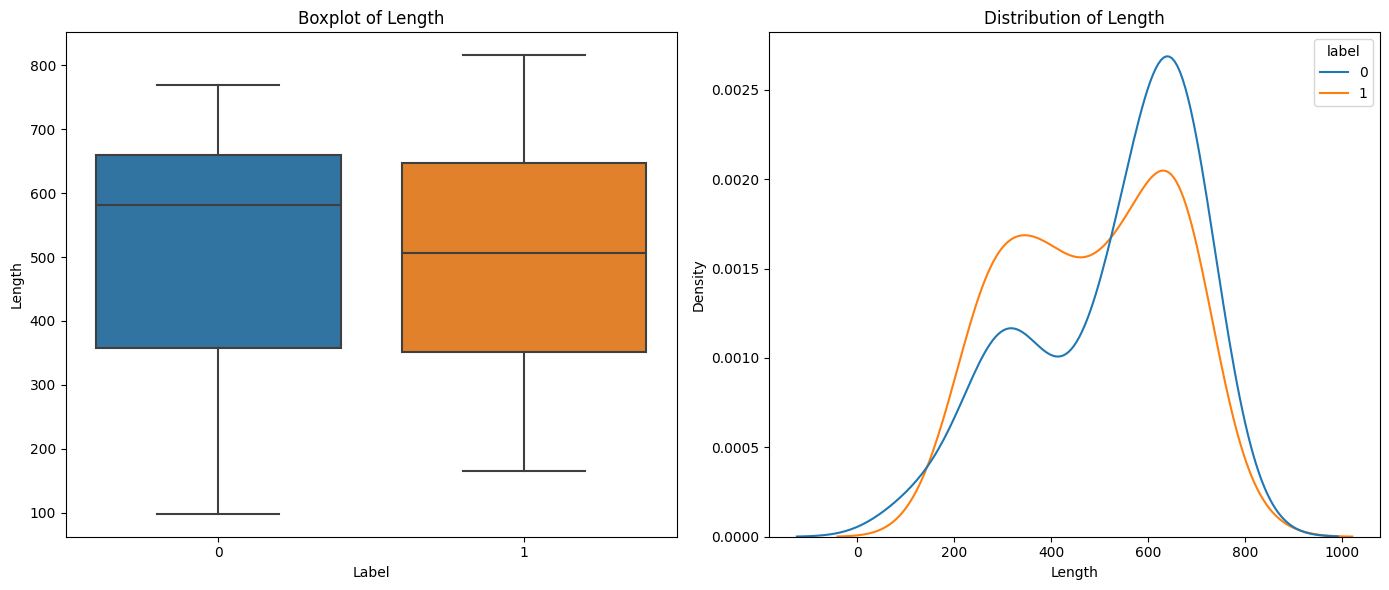

d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


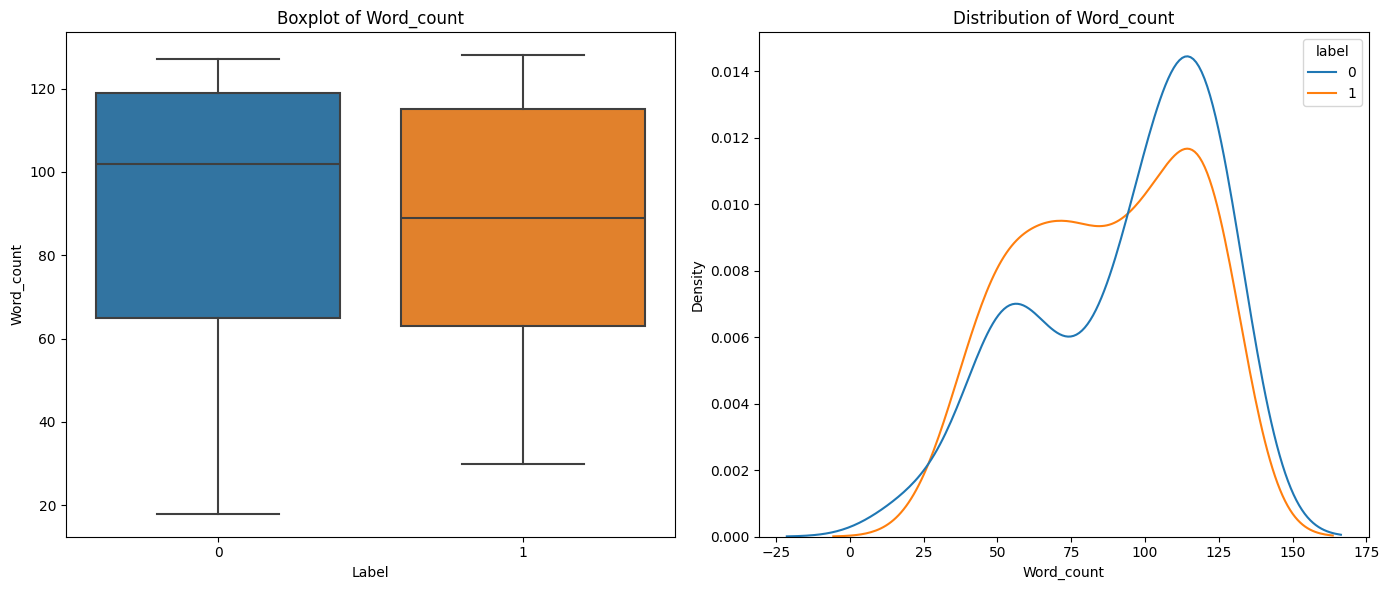

In [13]:
features = imdb_data.columns.tolist()[3:]
for feature in features:
    visualize(feature)

#### Term Frequency Analysis
Examining the most frequently occuring words is one of the most popular systems of Text analytics. For example, in a sentiment analysis problem, a positive text is bound to have words like 'good', 'great', 'nice', etc. more in number than other words that imply otherwise.

Note: Term Frequencies are more than counts and lenghts, so the first requirement is to preprocess the text

In [14]:
df = imdb_data.drop(features, axis=1)
df.head()

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


There is no missing data, therefore, we can move to the next stage. For Term frequency analysis, it is essential that the text data be preprocessed.

- Lowercase
- Remove punctutations
- Stopword removal

In [16]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

In [17]:
df['text'] = df['text'].apply(clean)
df.head(10)

,text,label,embedding
0,fairly good romantic comedy dont think ive eve...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,dressed kill one best thrillers ever made deal...,1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,im glad users date liked movie coming forward ...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed excuse get house paint dried - left mov...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candys performance upon crime possibly be...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."
5,movie maybe really bad alot fun bad acting poo...,1,"[0.0058481544000000005, -0.1326265633, 0.18759..."
6,besides boring scenes oppressive dark movie tr...,0,"[0.1397939026, -0.021955709900000002, 0.169891..."
7,exactly sort saturday matinee serial loved wor...,0,"[0.0405324325, 0.0174655784, 0.1514206231, 0.0..."
8,slick pre-hays code still sassy would highly r...,1,"[0.039149038500000004, -0.0511390641, 0.348277..."
9,like film lot wonderful chemistry actors tells...,1,"[-0.1012975574, 0.12617483740000002, 0.0768608..."


In [18]:
def corpus(text):
    text_list = text.split()
    return text_list

In [19]:
df['Review_lists'] = df['text'].apply(corpus)
df.head(10)

,text,label,embedding,Review_lists
0,fairly good romantic comedy dont think ive eve...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000...","[fairly, good, romantic, comedy, dont, think, ..."
1,dressed kill one best thrillers ever made deal...,1,"[-0.12526972590000002, 0.10147688540000001, 0....","[dressed, kill, one, best, thrillers, ever, ma..."
2,im glad users date liked movie coming forward ...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0....","[im, glad, users, date, liked, movie, coming, ..."
3,needed excuse get house paint dried - left mov...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0....","[needed, excuse, get, house, paint, dried, -, ..."
4,john candys performance upon crime possibly be...,1,"[0.1606466323, -0.1768193543, 0.35633808370000...","[john, candys, performance, upon, crime, possi..."
5,movie maybe really bad alot fun bad acting poo...,1,"[0.0058481544000000005, -0.1326265633, 0.18759...","[movie, maybe, really, bad, alot, fun, bad, ac..."
6,besides boring scenes oppressive dark movie tr...,0,"[0.1397939026, -0.021955709900000002, 0.169891...","[besides, boring, scenes, oppressive, dark, mo..."
7,exactly sort saturday matinee serial loved wor...,0,"[0.0405324325, 0.0174655784, 0.1514206231, 0.0...","[exactly, sort, saturday, matinee, serial, lov..."
8,slick pre-hays code still sassy would highly r...,1,"[0.039149038500000004, -0.0511390641, 0.348277...","[slick, pre-hays, code, still, sassy, would, h..."
9,like film lot wonderful chemistry actors tells...,1,"[-0.1012975574, 0.12617483740000002, 0.0768608...","[like, film, lot, wonderful, chemistry, actors..."


In [20]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Review_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<?, ?it/s]


7162

In [21]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('movie', 177),
 ('br', 124),
 ('film', 110),
 ('one', 66),
 ('good', 61),
 ('like', 50),
 ('dont', 42),
 ('see', 41),
 ('would', 39),
 ('story', 37)]

In [22]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

d:\Documents\spring 1403\Data Science\CA\Data-Science\.venv\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


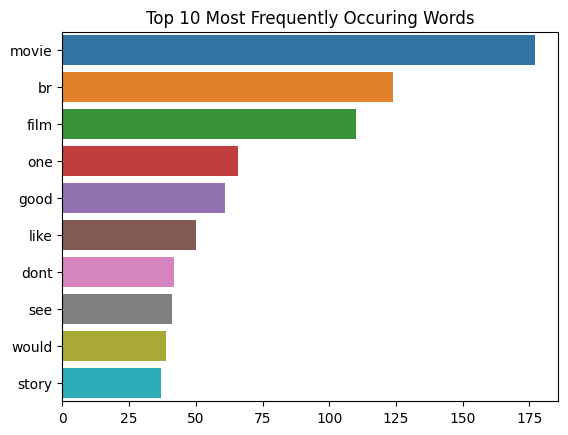

In [23]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

#### Most Frequently occuring N_grams
What is an N-gram?

An n-gram is sequence of n words in a text. Most words by themselves may not present the entire context. Typically adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyse phrases and not just words which can lead to better insights.

- A Bi-gram means two words in a sequence. 'Very good' or 'Too great'
- A Tri-gram means three words in a sequence. 'How was your day' would be broken down to 'How was your' and 'was your day'.

For separating text into n-grams, we will use CountVectorizer from Sklearn

In [24]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['text'])

In [25]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

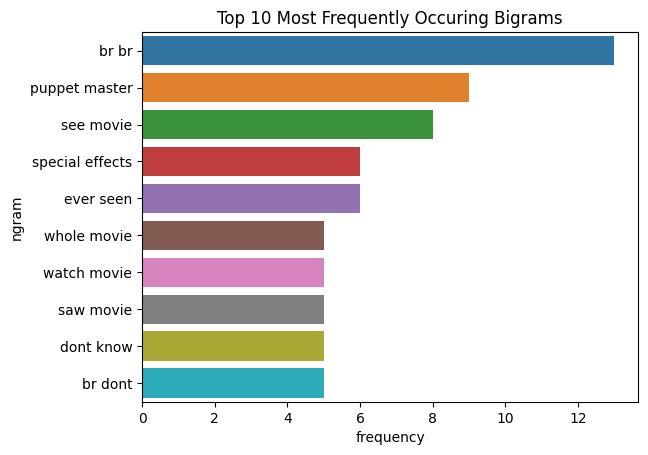

In [26]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [27]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

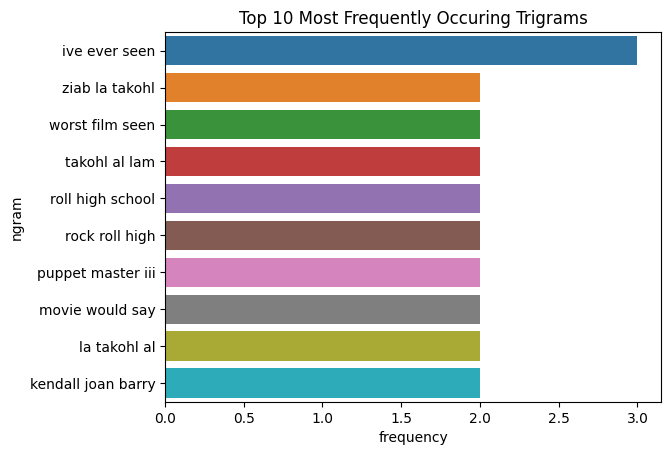

In [28]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

In [29]:
print(imdb_data['embedding'].describe())

count                                                   150
unique                                                  150
top       [-0.0167805497, -0.0395836979, 0.1233159453000...
freq                                                      1
Name: embedding, dtype: object


In [31]:
embeddings = np.vstack(imdb_data['embedding'].to_numpy())

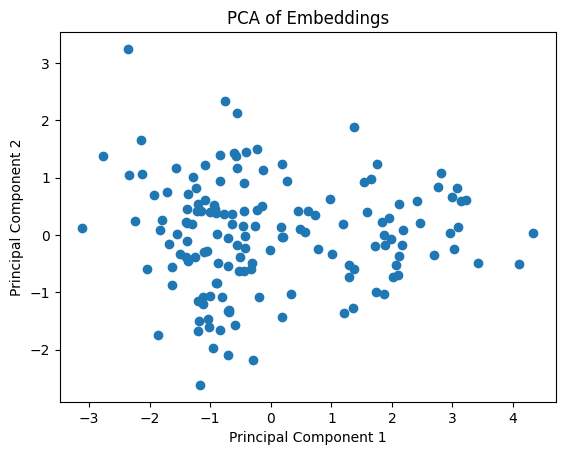

In [32]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot the reduced embeddings
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title('PCA of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

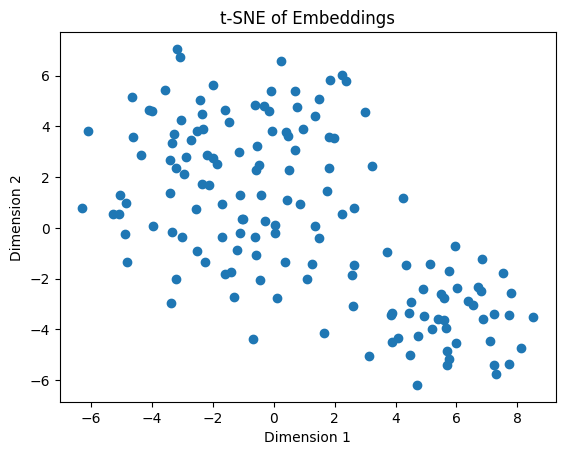

In [33]:
from sklearn.manifold import TSNE

# Reduce to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the reduced embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title('t-SNE of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


### Semi-Supervised

#### Label Propagation

In [36]:
from tqdm import tqdm

def calculate_silhouette_scores(X, max_clusters):
    scores = {}
    for i in tqdm(max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        scores[i] = score
    return scores


def plot_silhouette_scores(scores):
    plt.figure(figsize=(15, 6))
    plt.plot(list(scores.keys()), list(scores.values()))
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()



In [143]:
labeled_embeddings = np.vstack(imdb_data['embedding'].to_numpy())
embeddings_unlabeled = np.vstack(imdb_data_unlabeled['embedding'].to_numpy())
data = np.concatenate((labeled_embeddings, embeddings_unlabeled))

In [159]:
labels = np.vstack(imdb_data['label'].to_numpy())
labeled_indices = list(range(150))

In [178]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Number of clusters (can be tuned)
cluster_num = range(6, 50)
score = {i: [0, 0] for i in cluster_num}

for num_clusters in cluster_num:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    # Get cluster labels for each sample
    cluster_labels = kmeans.labels_
    cluster_to_label = defaultdict(int)
    for cluster in range(num_clusters):
        # Find indices of labeled samples in this cluster
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        cluster_labeled_indices = [i for i in cluster_indices if i in labeled_indices]
        
        if cluster_labeled_indices:
            cluster_labels_list = [labels[labeled_indices.index(i)] for i in cluster_labeled_indices]
            # Assign the majority label of labeled samples in this cluster
            flat_arr = np.concatenate(cluster_labels_list)
            # Count the occurrences of each number
            counts = np.bincount(flat_arr)
            # Find the most repeated number
            majority_label = np.argmax(counts)
            cluster_to_label[cluster] = majority_label


    # Propagate labels to all data
    propagated_labels = [cluster_to_label[cluster_labels[i]] for i in range(data.shape[0])]
    score[num_clusters][0] = sum(propagated_labels[:150]  == np.concatenate(labels))/150
    score[num_clusters][1] = silhouette_score(data, cluster_labels)



In [179]:
keys = list(score.keys())
values = list(score.values())
value1, value2 = zip(*values)

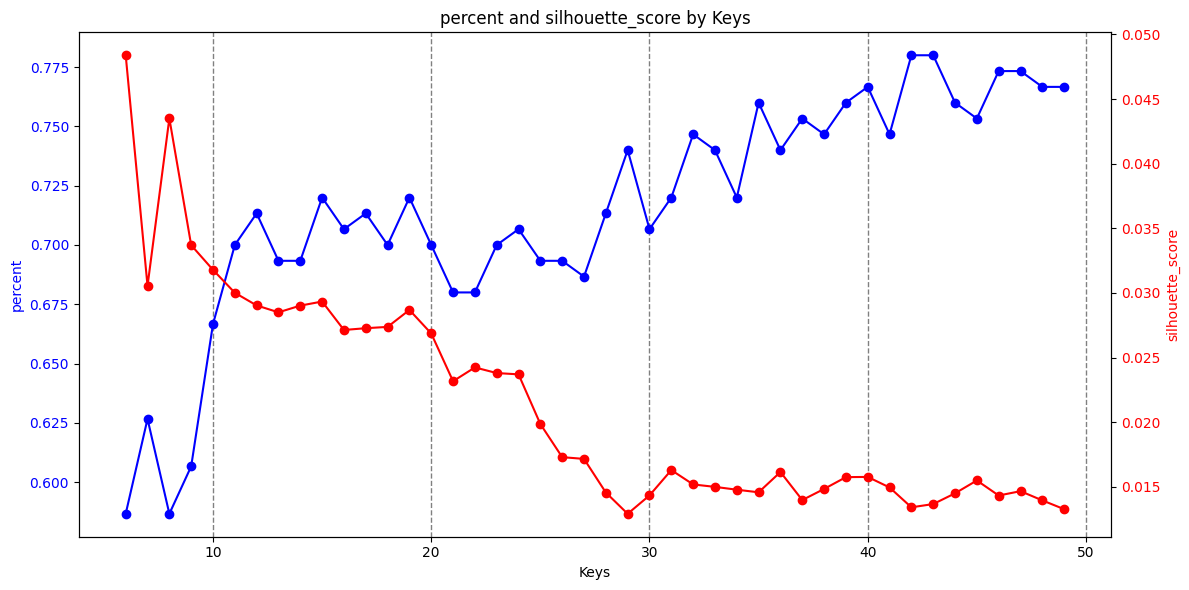

In [185]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot value1 on the left y-axis
ax1.plot(keys, value1, label='percent', color='blue', marker='o')
ax1.set_xlabel('Keys')
ax1.set_ylabel('percent', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.grid(True, linestyle='--', color='gray')

# Create a second y-axis for value2
ax2 = ax1.twinx()
ax2.plot(keys, value2, label='silhouette_score', color='red', marker='o')
ax2.set_ylabel('silhouette_score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and show the plot
plt.title('percent and silhouette_score by Keys')
fig.tight_layout()  # Adjust layout to make room for both y-axes
plt.show()

In [186]:
num_clusters = 42
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data)

# Get cluster labels for each sample
cluster_labels = kmeans.labels_
cluster_to_label = defaultdict(int)
for cluster in range(num_clusters):
    # Find indices of labeled samples in this cluster
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
    cluster_labeled_indices = [i for i in cluster_indices if i in labeled_indices]
    
    if cluster_labeled_indices:
        cluster_labels_list = [labels[labeled_indices.index(i)] for i in cluster_labeled_indices]
        # Assign the majority label of labeled samples in this cluster
        flat_arr = np.concatenate(cluster_labels_list)
        # Count the occurrences of each number
        counts = np.bincount(flat_arr)
        # Find the most repeated number
        majority_label = np.argmax(counts)
        cluster_to_label[cluster] = majority_label


    # Propagate labels to all data
    propagated_labels = [cluster_to_label[cluster_labels[i]] for i in range(data.shape[0])]

In [187]:
from scipy.spatial.distance import cdist

# Calculate distances to cluster centers
distances = cdist(embeddings, kmeans.cluster_centers_, 'euclidean')

# For each cluster, identify and remove the furthest 5% of points
outliers_indices = []
for cluster in range(num_clusters):
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
    cluster_distances = distances[cluster_indices, cluster]
    threshold = np.percentile(cluster_distances, 95)
    outliers = [cluster_indices[i] for i in range(len(cluster_indices)) if cluster_distances[i] > threshold]
    outliers_indices.extend(outliers)

# Remove outliers
filtered_indices = [i for i in range(embeddings.shape[0]) if i not in outliers_indices]
filtered_embeddings = embeddings[filtered_indices]
filtered_labels = [propagated_labels[i] for i in filtered_indices]


IndexError: index 289 is out of bounds for axis 0 with size 150